In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, isnull, count , when , expr , format_number , lit ,datediff, month, when,to_timestamp
from pyspark.sql.types import DoubleType, IntegerType, FloatType,DateType
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

# Initialiser SparkSession
spark = SparkSession.builder.appName("Projet Spark").getOrCreate()
# Charger le dataset
dataset_path = "../data/GlobalFireBurnedArea_2022.csv"
df = spark.read.csv(dataset_path, header=True,inferSchema=True)

# Convertir le dataframe Spark en dataframe Pandas
pandas_df = df.toPandas()

pd.set_option("display.max_columns",9)
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.width", 130)
# Afficher les 10 premières lignes avec Pandas
print(pandas_df.head(10))

         ID       Initialdate         Finaldate      Area_ha      Area_m2    Area_Km2          CountryName   Continent  \
0  25078590  2022/01/09 00:00  2022/02/06 00:00  50232.10763  502321076.3  502.321076                Ghana      Africa   
1  25079092  2022/01/11 00:00  2022/02/08 00:00  82380.29538  823802953.8  823.802954              Nigeria      Africa   
2  25079113  2022/01/11 00:00  2022/02/03 00:00  36851.12748  368511274.8  368.511275              Nigeria      Africa   
3  25083241  2022/01/03 00:00  2022/02/12 00:00  43303.63519  433036351.9  433.036352              Nigeria      Africa   
4  25095507  2022/01/01 00:00  2022/02/11 00:00  75753.14059  757531405.9  757.531406     Central Afric...      Africa   
5  25097833  2022/01/24 00:00  2022/02/11 00:00  19493.13211  194931321.1  194.931321     Central Afric...      Africa   
6  25100371  2022/01/22 00:00  2022/02/09 00:00  43237.30588  432373058.8  432.373059     Central Afric...      Africa   
7  25100424  2022/01/24 

In [3]:
# Nombre de lignes et de colonnes
num_rows = df.count()
num_cols = len(df.columns)

print(f"Le DataFrame contient {num_rows} lignes et {num_cols} colonnes.")


Le DataFrame contient 319278 lignes et 9 colonnes.


In [24]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Initialdate: date (nullable = true)
 |-- Finaldate: date (nullable = true)
 |-- Area_ha: double (nullable = true)
 |-- Area_m2: double (nullable = true)
 |-- Area_Km2: double (nullable = true)
 |-- CountryName: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Region: string (nullable = true)



In [21]:
# Compter les valeurs nulles pour chaque colonne
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+-----------+---------+-------+-------+--------+-----------+---------+------+
| ID|Initialdate|Finaldate|Area_ha|Area_m2|Area_Km2|CountryName|Continent|Region|
+---+-----------+---------+-------+-------+--------+-----------+---------+------+
|  0|          0|        0|      0|      0|       0|          0|        0|     0|
+---+-----------+---------+-------+-------+--------+-----------+---------+------+



In [65]:
df = df.withColumn("Area_ha", col("Area_ha").cast(DoubleType()))
df = df.withColumn("Initialdate", col("Initialdate").cast(DateType()))
df = df.withColumn("Finaldate", col("Finaldate").cast(DateType()))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Initialdate: date (nullable = true)
 |-- Finaldate: date (nullable = true)
 |-- Area_ha: double (nullable = true)
 |-- Area_m2: double (nullable = true)
 |-- Area_Km2: double (nullable = true)
 |-- CountryName: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Season: string (nullable = false)
 |-- Duration_days: integer (nullable = true)



In [25]:
# Étape 1 : Calculer les statistiques descriptives
stats_df = df.select("Area_ha", "Area_m2", "Area_Km2").summary("mean", "stddev", "min", "max")

# Étape 2 : Convertir les colonnes en DoubleType
stats_df = stats_df.withColumn("Area_ha", col("Area_ha").cast(DoubleType())) \
                   .withColumn("Area_m2", col("Area_m2").cast(DoubleType())) \
                   .withColumn("Area_Km2", col("Area_Km2").cast(DoubleType()))

# Étape 3 : Appliquer format_number pour un affichage lisible
formatted_stats_df = stats_df.select(
    col("summary"),
    format_number("Area_ha", 2).alias("Area_ha"),
    format_number("Area_m2", 2).alias("Area_m2"),
    format_number("Area_Km2", 2).alias("Area_Km2")
)

# Afficher le DataFrame formaté
formatted_stats_df.show()


+-------+------------+-----------------+---------+
|summary|     Area_ha|          Area_m2| Area_Km2|
+-------+------------+-----------------+---------+
|   mean|      878.33|     8,783,305.58|     8.78|
| stddev|   13,756.50|   137,564,988.07|   137.56|
|    min|      106.85|     1,068,459.57|     1.07|
|    max|6,092,464.36|60,924,643,559.00|60,924.64|
+-------+------------+-----------------+---------+



In [32]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = assembler.transform(df).select("features")
matrix = Correlation.corr(vector_df, "features").head()[0]
correlation_matrix = np.array(matrix.toArray())
print("Matrice de corrélation :\n", correlation_matrix)

Matrice de corrélation :
 [[1.         0.00971099 0.00971099 0.00971099]
 [0.00971099 1.         1.         1.        ]
 [0.00971099 1.         1.         1.        ]
 [0.00971099 1.         1.         1.        ]]


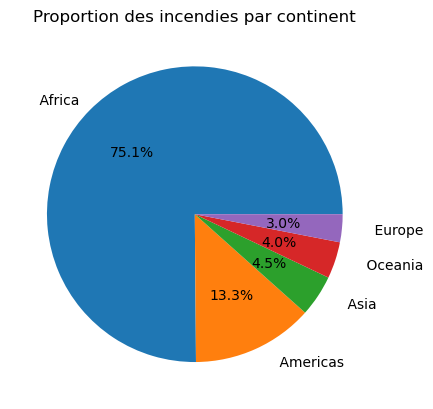

Ce diagramme illustre la proportion d'incendies survenant sur chaque continent. L'Afrique est de loin le continent le plus touché, concentrant 75,1% des incendies mondiaux.


In [41]:
pandas_df['Continent'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion des incendies par continent")
plt.ylabel('')
plt.show()
print("Ce diagramme illustre la proportion d'incendies survenant sur chaque continent. L'Afrique est de loin le continent le plus touché, concentrant 75,1% des incendies mondiaux.")

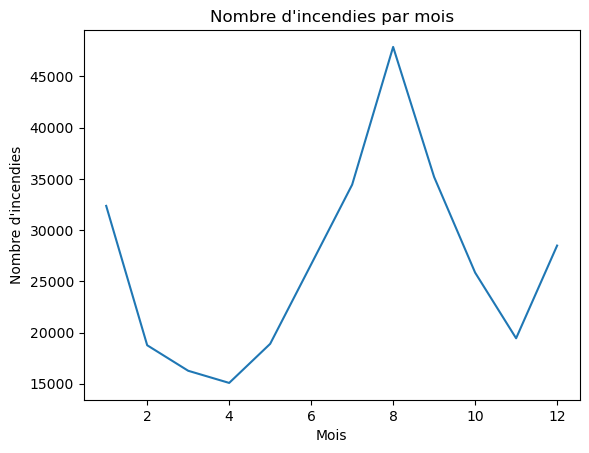

Le graphique présente le nombre d incendies enregistrés chaque mois sur une période d un an. On observe un pic significatif au cours des mois juillet et août, suggérant une saisonnalité liée à des conditions météorologiques plus sèches et chaudes.


In [40]:
pandas_df['Month'] = pd.to_datetime(pandas_df['Initialdate']).dt.month
incendies_par_mois = pandas_df.groupby('Month').size()
incendies_par_mois.plot(kind='line')
plt.title("Nombre d'incendies par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'incendies")
plt.show()
print("Le graphique présente le nombre d incendies enregistrés chaque mois sur une période d un an. On observe un pic significatif au cours des mois juillet et août, suggérant une saisonnalité liée à des conditions météorologiques plus sèches et chaudes.")


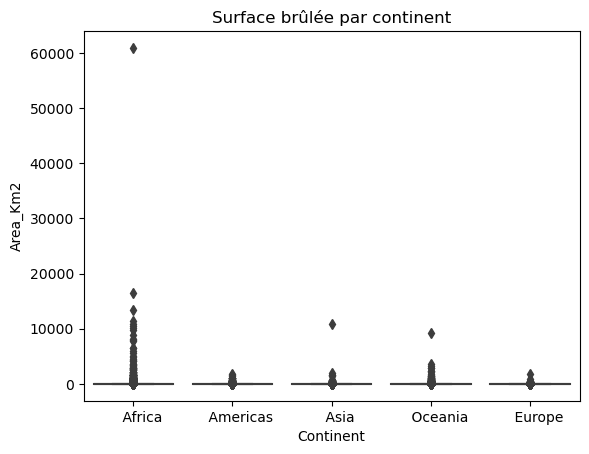

La représentation ci-dessus montre que la surface brûlée par les incendies varie considérablement d'un continent à l'autre. L'Afrique se distingue par une fréquence et une intensité plus élevées des feux de forêt.


In [45]:

sns.boxplot(x='Continent', y='Area_Km2', data=pandas_df)
plt.title("Surface brûlée par continent")
plt.show()
print("La représentation ci-dessus montre que la surface brûlée par les incendies varie considérablement d'un continent à l'autre. L'Afrique se distingue par une fréquence et une intensité plus élevées des feux de forêt.")

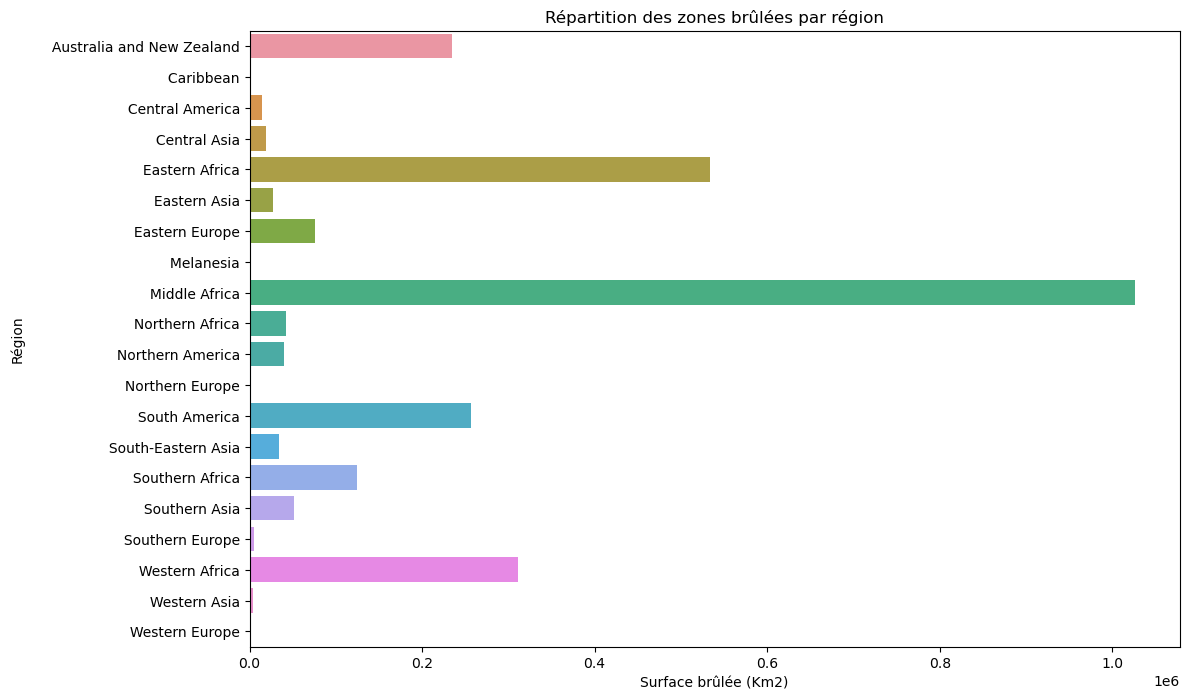

La répartition géographique des surfaces brûlées met en évidence une forte concentration dans certaines régions d'Afrique, notamment en Afrique centrale. Cette situation soulève des questions cruciales quant à la gestion durable des ressources naturelles et à la lutte contre le changement climatique.


In [48]:
# Somme des zones brûlées par région
df_region = pandas_df.groupby('Region')['Area_Km2'].sum().reset_index()

# Bar plot pour la répartition par région
plt.figure(figsize=(12, 8))
sns.barplot(x='Area_Km2', y='Region', data=df_region)
plt.title("Répartition des zones brûlées par région")
plt.xlabel("Surface brûlée (Km2)")
plt.ylabel("Région")
plt.show()
print("La répartition géographique des surfaces brûlées met en évidence une forte concentration dans certaines régions d'Afrique, notamment en Afrique centrale. Cette situation soulève des questions cruciales quant à la gestion durable des ressources naturelles et à la lutte contre le changement climatique." )

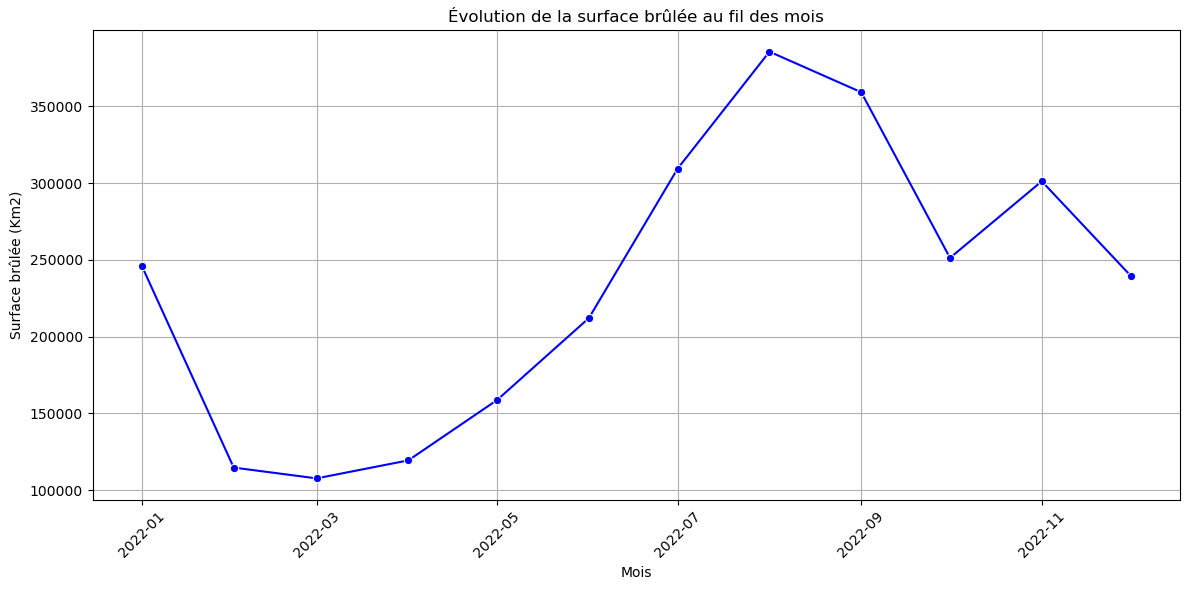

Ce graphique illustre l'évolution de la superficie totale brûlée par les incendies chaque mois en 2022. On observe une forte augmentation des surfaces brûlées à partir du mois de juin, avec un pic en août, avant une diminution progressive jusqu'à la fin de l'année.


In [55]:
pandas_df['Initialdate'] = pd.to_datetime(pandas_df['Initialdate'])

# Extraire l'année et le mois de la date
pandas_df['YearMonth'] = pandas_df['Initialdate'].dt.to_period('M')

# Grouper les données par mois et année, et calculer la somme de la surface brûlée
df_monthly = pandas_df.groupby('YearMonth')['Area_Km2'].sum().reset_index()

# Convertir 'YearMonth' en datetime pour faciliter le tracé
df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

# Créer un graphique de tendance (line plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='Area_Km2', data=df_monthly, marker='o', color='b')
plt.title("Évolution de la surface brûlée au fil des mois")
plt.xlabel("Mois")
plt.ylabel("Surface brûlée (Km2)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Ce graphique illustre l'évolution de la superficie totale brûlée par les incendies chaque mois en 2022. On observe une forte augmentation des surfaces brûlées à partir du mois de juin, avec un pic en août, avant une diminution progressive jusqu'à la fin de l'année.")

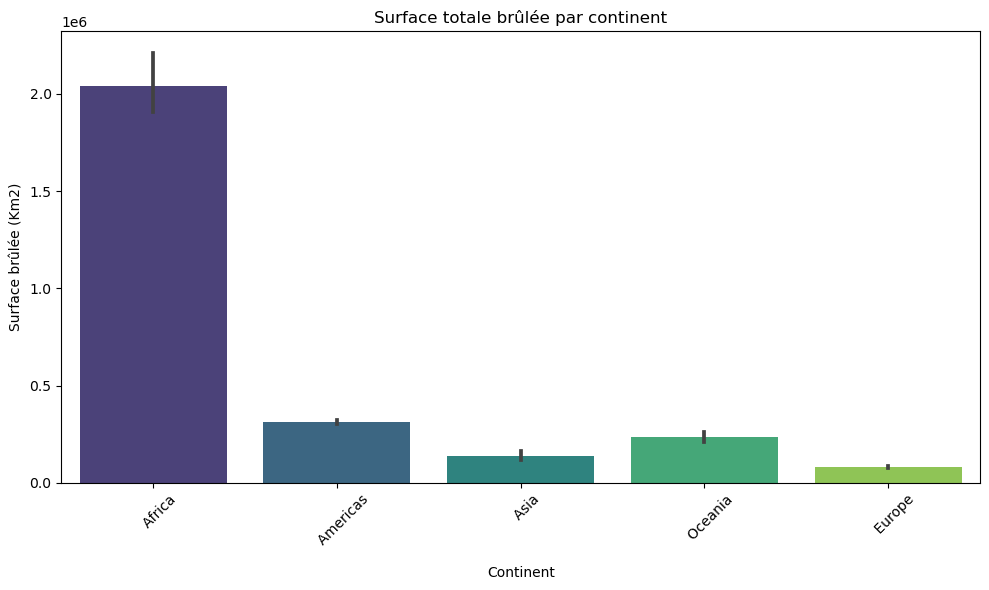

La représentation ci-dessus montre que les impacts des incendies varient considérablement d'un continent à l'autre. L'Afrique se distingue par des surfaces brûlées bien supérieures à la moyenne des autres continents.


In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Continent', y='Area_Km2', data=pandas_df, estimator='sum', palette='viridis')
plt.title("Surface totale brûlée par continent")
plt.xlabel("Continent")
plt.ylabel("Surface brûlée (Km2)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("La représentation ci-dessus montre que les impacts des incendies varient considérablement d'un continent à l'autre. L'Afrique se distingue par des surfaces brûlées bien supérieures à la moyenne des autres continents.")

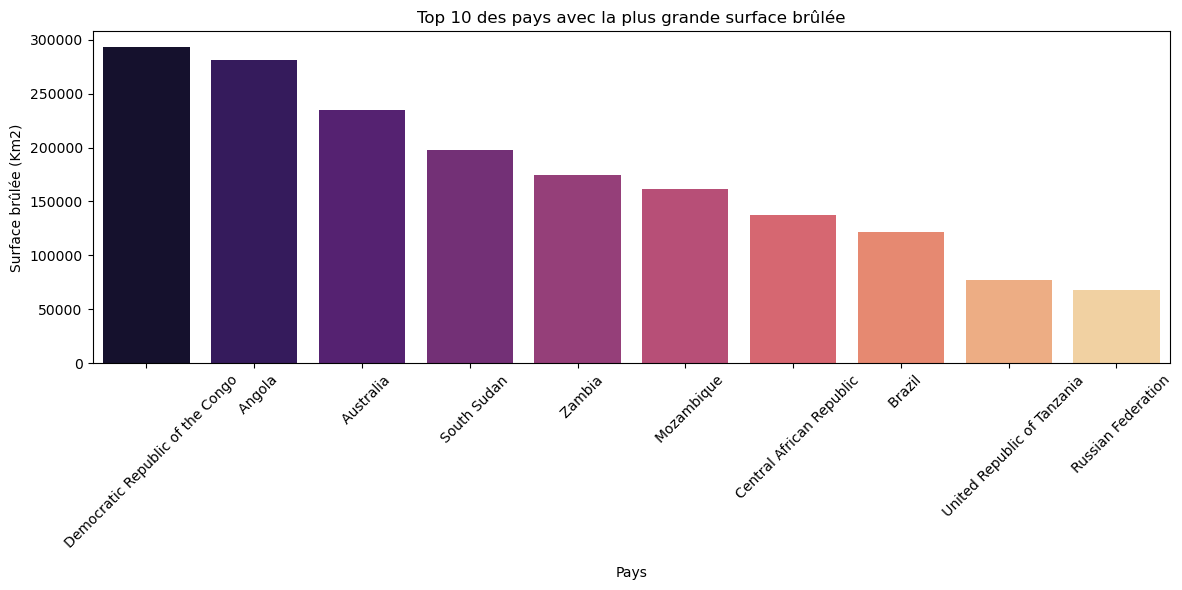

Ce graphique présente le top 10 des pays ayant été les plus touchés par les incendies en termes de superficie brûlée. La République démocratique du Congo arrive en tête, suivie de près par l'Angola.


In [61]:
top_countries = pandas_df.groupby('CountryName')['Area_Km2'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='CountryName', y='Area_Km2', data=top_countries, palette='magma')
plt.title("Top 10 des pays avec la plus grande surface brûlée")
plt.xlabel("Pays")
plt.ylabel("Surface brûlée (Km2)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("Ce graphique présente le top 10 des pays ayant été les plus touchés par les incendies en termes de superficie brûlée. La République démocratique du Congo arrive en tête, suivie de près par l'Angola.")

In [4]:


# Extraire la saison à partir de `Initialdate`
df = df.withColumn("Initialdate", to_timestamp("Initialdate", "yyyy/MM/dd HH:mm"))
df = df.withColumn("Finaldate", to_timestamp("Finaldate", "yyyy/MM/dd HH:mm"))
df = df.withColumn(
    "Season",
    when((month("Initialdate") <= 2) | (month("Initialdate") == 12), "Winter")
    .when((month("Initialdate") >= 3) & (month("Initialdate") <= 5), "Spring")
    .when((month("Initialdate") >= 6) & (month("Initialdate") <= 8), "Summer")
    .otherwise("Autumn")
)

# Calculer la durée de l'incendie
df = df.withColumn("Duration_days", datediff("Finaldate", "Initialdate"))

# Afficher un aperçu pour vérifier
pandas_df_updated = df.toPandas()
print(pandas_df_updated.head(10))



         ID Initialdate  Finaldate      Area_ha  ...   Continent               Region  Season Duration_days
0  25078590  2022-01-09 2022-02-06  50232.10763  ...      Africa       Western Africa  Winter            28
1  25079092  2022-01-11 2022-02-08  82380.29538  ...      Africa       Western Africa  Winter            28
2  25079113  2022-01-11 2022-02-03  36851.12748  ...      Africa       Western Africa  Winter            23
3  25083241  2022-01-03 2022-02-12  43303.63519  ...      Africa       Western Africa  Winter            40
4  25095507  2022-01-01 2022-02-11  75753.14059  ...      Africa        Middle Africa  Winter            41
5  25097833  2022-01-24 2022-02-11  19493.13211  ...      Africa        Middle Africa  Winter            18
6  25100371  2022-01-22 2022-02-09  43237.30588  ...      Africa        Middle Africa  Winter            18
7  25100424  2022-01-24 2022-02-06  19983.66856  ...      Africa        Middle Africa  Winter            13
8  25117856  2022-01-07 2022

In [7]:
df.coalesce(1).write.csv("../data/Transformed_GlobalFireBurnedArea.csv", header=True, mode="overwrite")

# Recharger les données dans une nouvelle session
df_new = spark_new.read.csv("../data/Transformed_GlobalFireBurnedArea.csv", header=True, inferSchema=True)
df_new.show()


Py4JJavaError: An error occurred while calling o91.csv.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$writeAndCommit$3(FileFormatWriter.scala:275)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:275)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:243)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:860)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1570)
